In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

DATA_DIR = Path(
    "/home/christian/Documents/research/MIST/mistsim/examples/data/"
)

## Simulation cases

Test 0: Mars Site 2, mountain blockage up to 10 deg (nominal) \
Test 1: Same as 1, except no mountains \
Test 2: North Pole, no mountains

In [2]:
tests = {0: "MARS / with mountains", 1: "MARS / no mountains", 2: "North Pole / no mountains"}
sim_res = {"raul": {}, "chb": {}}

## Raul's simulations

In [3]:
import h5py


def read_hdf5_convolution(path_file, print_key=False):
    with h5py.File(path_file, "r") as hf:
        if print_key:
            print([key for key in hf.keys()])

        hfX = hf.get("lst")
        lst = np.array(hfX)
        hfX = hf.get("freq")
        freq = np.array(hfX)
        hfX = hf.get("ant_temp")
        ant_temp = np.array(hfX)

    return lst, freq, ant_temp

# test 0
path = Path(DATA_DIR) / Path("20260215_for_christian/antenna_temperature_20260215_test1.hdf5")
lst, freqs, ant_temp_r = read_hdf5_convolution(path, print_key=True)
sim_res["raul"][0] = ant_temp_r

# test 1
path = Path(DATA_DIR) / Path("20260220_for_christian/antenna_temperature_20260220_test1.hdf5")
_lst, _freqs, ant_temp_r = read_hdf5_convolution(path, print_key=True)
assert np.allclose(lst, _lst)
assert np.allclose(freqs, _freqs)
sim_res["raul"][1] = ant_temp_r

# test 2
path = Path(DATA_DIR) / Path("20260220_for_christian/antenna_temperature_20260220_test2.hdf5")
_lst, _freqs, ant_temp_r = read_hdf5_convolution(path, print_key=True)
# assert np.allclose(lst, _lst)
lst_np = _lst  # north pole lst
assert np.allclose(freqs, _freqs)
sim_res["raul"][2] = ant_temp_r


lsts = {0: lst, 1: lst, 2: lst_np}

['ant_temp', 'freq', 'lst']
['ant_temp', 'freq', 'lst']
['ant_temp', 'freq', 'lst']


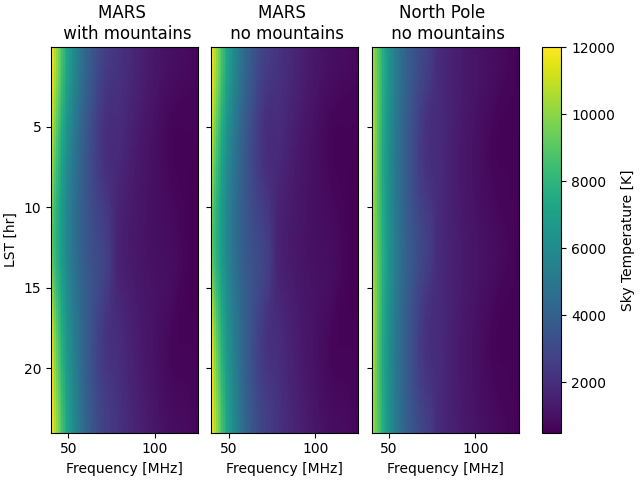

In [4]:
wfall_kwargs = {
    "extent": [freqs[0], freqs[-1], lst[-1], lst[0]],  # not exact for np
    "interpolation": "none",
    "aspect": "auto",
    "vmin": 500,
    "vmax": 12000,
}

fig, axs = plt.subplots(
    nrows=1, ncols=3, sharex=True, sharey=True, constrained_layout=True,
)
for k, v in sim_res["raul"].items():
    im = axs[k].imshow(v, **wfall_kwargs)
    axs[k].set_title("\n".join(tests[k].split("/")))
    axs[k].set_xlabel("Frequency [MHz]")
axs[0].set_ylabel("LST [hr]")
fig.colorbar(im, ax=axs, label="Sky Temperature [K]")
plt.show()

## MISTSIM

In [5]:
import jax
import jax.numpy as jnp

jax.config.update('jax_enable_x64', True)

In [6]:
import astropy.units as u
import healpy as hp
import s2fft
from astropy.coordinates import EarthLocation
from astropy.io import fits
from astropy.time import Time
import croissant as cro

import mistsim as ms

In [7]:
NSIDE = 128
SIM_LMAX = 100

## Sky model

In [8]:
def load_haslam(fname="20260215_for_christian/haslam408_ds_Remazeilles2014.fits"):
    fpath = DATA_DIR / Path(fname)
    with fits.open(fpath) as hdul:
        hdul.info()
        data = hdul[1].data
        header = hdul[1].header
    return data, header

def scale_map(m, freqs, beta=-2.55, f0=408, tcmb=2.725):
    scale = (freqs/f0)**beta
    return (m-tcmb)[None, :] * scale[:, None] + tcmb

data, hdr = load_haslam()
# map is in galactic, nside=512, ordering=ring
haslam = data["TEMPERATURE"].ravel()
haslam = hp.ud_grade(haslam, NSIDE, order_in="RING")
haslam = scale_map(haslam, freqs)

sky_model = ms.Sky(haslam, freqs, sampling="healpix", coord="galactic")

Filename: /home/christian/Documents/research/MIST/mistsim/examples/data/20260215_for_christian/haslam408_ds_Remazeilles2014.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     42   3072R x 1C   [1024E]   


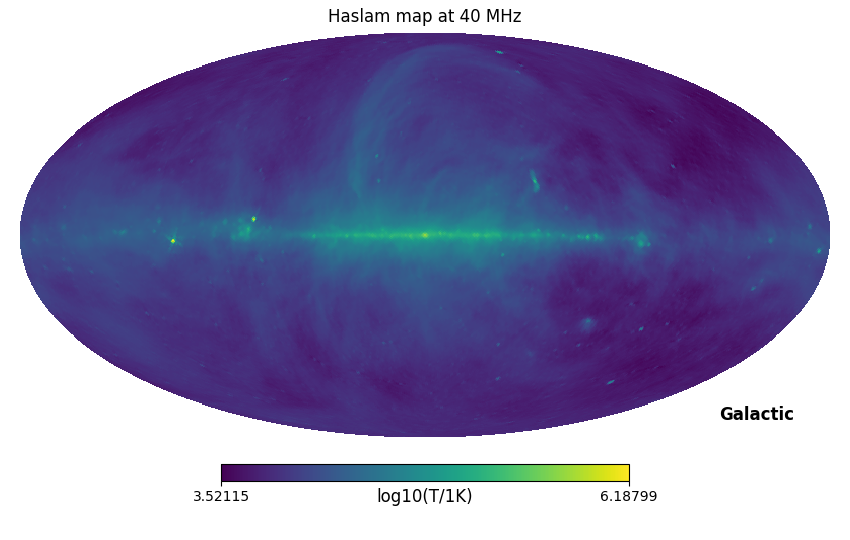

In [9]:
hp.mollview(
    np.log10(sky_model.data[0]),
    coord="G",
    title=f"Haslam map at {freqs[0]:.0f} MHz",
    cbar=True,
    unit="log10(T/1K)",
)
plt.show()

## Beam model

Frequencies match: True
(86, 181, 360)


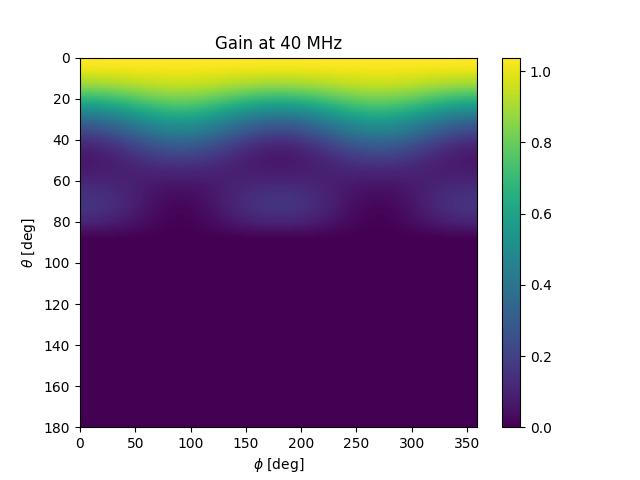

In [10]:
def load_beam(fname="20260215_for_christian/beam.npz"):
    d = np.load(DATA_DIR / Path(fname))
    freqs = d["freqs"]
    phi = d["phi"]
    theta = d["theta"]
    gain = d["gain"]
    return freqs, phi, theta, gain

freqs_beam, phi, theta, gain_above = load_beam()

# need to restrict to same freq range as sky
fix = np.isin(freqs_beam/1e6, freqs)
gain_above = gain_above[fix]
freqs_beam = freqs_beam[fix]
print(f"Frequencies match: {np.allclose(freqs_beam/1e6, freqs)}")

# theta needs to go 0 to 180
gain_below = np.zeros_like(gain_above[:, :-1, :])
gain = np.concatenate((gain_above, gain_below), axis=1)
print(gain.shape)

theta = np.concatenate((theta, np.arange(91, 181)))


plt.figure()
plt.imshow(
    gain[0], aspect="auto", interpolation="none", extent=[0, 359, 180, 0]
)
plt.colorbar()
plt.title(f"Gain at {freqs[0]:.0f} MHz")
plt.xlabel("$\\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.show()

In [11]:
# no mountain case (test 1 and 2)
beam2 = ms.Beam(gain, freqs, sampling="mwss", horizon=None)

# with mountain blockage
horizon = theta <= 80
horizon = horizon[:, None]
beam1 = ms.Beam(gain, freqs, sampling="mwss", horizon=horizon)

# test 0: with mountains, 1,2: no mountains
beams = {0: beam1, 1: beam2, 2: beam2}

## Simulator

In [12]:
# define observation time and location

# mars
lon = -90.74750
lat = 79.41833
alt = 150
loc = EarthLocation.from_geodetic(lon, lat, height=alt)
locs = {0: loc, 1: loc}

# north pole
np_loc = EarthLocation.from_geodetic(0, 90, height=0)
locs[2] = np_loc
print(locs)


def lst_to_time(lst_arr, t0):
    """
    Convert array of LST to array of astropy Time objects
    for use with croissant

    Parameters
    ----------
    lst_arr : array_like
        List of LST in hrs
    t0 : Time
        Reference time.
    """
    lst_ref = t0.sidereal_time("mean").hour
    delta = (lst_arr - lst_ref) /24 * u.sday
    times = t0 + delta
    return times

times = {}
for k, loc in locs.items():
    t0 = Time("2022-07-17 00:00", location=loc)
    times[k] = lst_to_time(lsts[k], t0)

for k, t in times.items():
    print(f"LST match: {np.allclose(t.sidereal_time('mean').hour, lsts[k])}")

{0: <EarthLocation (-15330.25523412, -1174995.43673812, 6248087.82372465) m>, 1: <EarthLocation (-15330.25523412, -1174995.43673812, 6248087.82372465) m>, 2: <EarthLocation (3.91862092e-10, 0., 6356752.31424518) m>}
LST match: True
LST match: True
LST match: True


In [16]:
sims = {}

for k in range(3):
    print(f"Set up simulation {k}")
    beam = beams[k]
    times_jd = times[k].jd
    lon = locs[k].lon.deg
    lat = locs[k].lat.deg
    alt = locs[k].height.value
    sim = ms.Simulator(
        beam,
        sky_model,
        times_jd,
        freqs,
        lon,
        lat,
        alt=alt,
        lmax=SIM_LMAX,
        Tgnd=0,
    )
    sims[k] = sim

Set up simulation 0
Set up simulation 1
Set up simulation 2


In [17]:
tants = {}
for k, sim in sims.items():
    print(f"Run simulation {k}")
    tant = sim.sim()
    tants[k] = tant
    fgnd = sim.beam.compute_fgnd()
    tsky = cro.simulator.correct_ground_loss(tant, fgnd, 0)  # Tgnd=0
    sim_res["chb"][k] = tsky

Run simulation 0
Run simulation 1
Run simulation 2


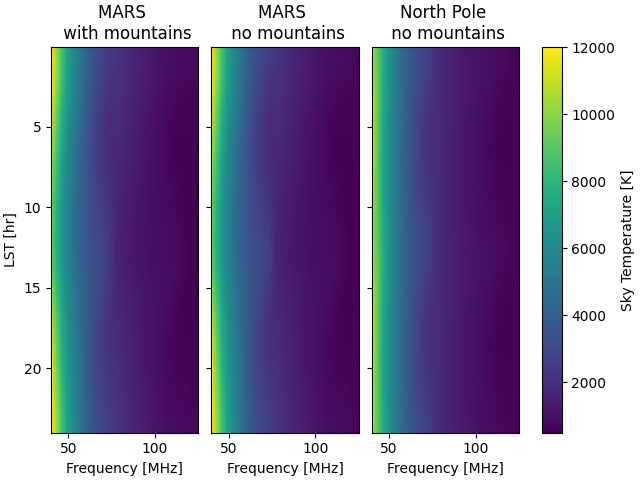

In [18]:
fig, axs = plt.subplots(
    nrows=1, ncols=3, sharex=True, sharey=True, constrained_layout=True,
)
for k, v in sim_res["chb"].items():
    im = axs[k].imshow(v, **wfall_kwargs)
    axs[k].set_title("\n".join(tests[k].split("/")))
    axs[k].set_xlabel("Frequency [MHz]")
axs[0].set_ylabel("LST [hr]")
fig.colorbar(im, ax=axs, label="Sky Temperature [K]")
plt.show()

## Compare Raul's sim with MISTSIM

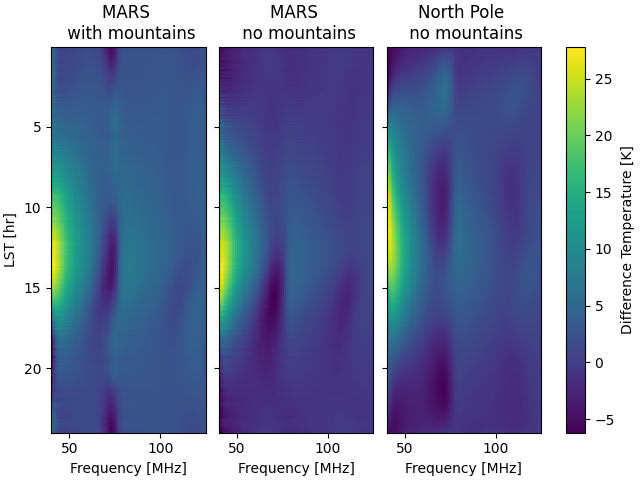

In [19]:
diff_kwargs = wfall_kwargs.copy()
diff_kwargs["vmin"] = None
diff_kwargs["vmax"] = None

fig, axs = plt.subplots(
    nrows=1, ncols=3, sharex=True, sharey=True, constrained_layout=True,
)
for k, v in sim_res["chb"].items():
    raul_sim = sim_res["raul"][k]
    im = axs[k].imshow(raul_sim - v, **diff_kwargs)
    axs[k].set_title("\n".join(tests[k].split("/")))
    axs[k].set_xlabel("Frequency [MHz]")
axs[0].set_ylabel("LST [hr]")
fig.colorbar(im, ax=axs, label="Difference Temperature [K]")
plt.show()

## Save results

In [29]:
def flatten_dict(d):
    """
    Flatten a nestesd dictionary
    """
    flat_d = {}
    for outerkey, inner in d.items():
        for innerkey, v in inner.items():
            k = "-".join([str(outerkey), str(innerkey)])
            flat_d[k] = np.asarray(v)
    return flat_d

In [40]:
flat_res = flatten_dict(sim_res)
np.savez("comparison_022526.npz", **flat_res, sky_map=sky_model.data, beam_data=beam1.data, freqs=freqs, lst=lst, tests=tests)